<a href="https://colab.research.google.com/github/adamd1985/Lectures_On_MLAI/blob/main/3_Data_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Data Engineering


It is assumed you have understood the introduction to AI notebook [here](https://colab.research.google.com/drive/1UsuLOvdM1SxkumRh2bzCverG8qt3VJMh?usp=sharing).

In the lessons we used the example of a salary toy dataset, we will create one here with random entries.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd

np.random.seed(42)
N_SAMPLES = 100
MILLIONAIRE_CHANCE = 0.01
PERCENT_FEMALES = 0.1
DEPARTMENTS = ['Engineering', 'Sales', 'HR', 'Marketing']
MANAGERS = ['CEO', 'Manager']

def generate_salary_toydataset(n, million_chance=MILLIONAIRE_CHANCE, female_perc=PERCENT_FEMALES):
    np.random.seed(42)
    ages = np.random.randint(21, 50, size=n)
    salaries = np.where(
        ages < 25,
        np.random.randint(21000, 38001, size=n),
        np.random.randint(32000, 65001, size=n)
    )
    millionaire_indices = np.random.choice(n, size=int(million_chance * n), replace=False)
    salaries[millionaire_indices] = np.random.randint(900_000, 1_500_001, size=len(millionaire_indices))
    genders = np.random.choice(['Male', 'Female'], size=n, p=[1. - female_perc, female_perc])
    departments = np.random.choice(DEPARTMENTS, size=n)
    reports_to = np.random.choice(MANAGERS, size=n, p=[0.05, 0.95])

    salary_df = pd.DataFrame({
        'Name': [f'Person_{i}' for i in range(n)],
        'Age': ages,
        'Salary': salaries,
        'Gender': genders,
        'Department': departments,
        'Reports_To': reports_to
    })
    return salary_df

salary_df = generate_salary_toydataset(n=N_SAMPLES)
salary_df.sample(3)

,Name,Age,Salary,Gender,Department,Reports_To
10,Person_10,39,51360,Male,HR,Manager
71,Person_71,48,59643,Male,HR,Manager
65,Person_65,46,37895,Male,Sales,Manager


## Feature Engineering

### Outlier and Outlier Removal

In the lesson we talked about outliers, let's see in code how these affect your data distributions.

We will import another visualization library called `seaborn`. If you are running locally, you will have to install it.
Also, we will import `scipy` which contains a collection of mathematical apis and algorithms useful for machine learning. Read the API [here](https://scipy.org/).

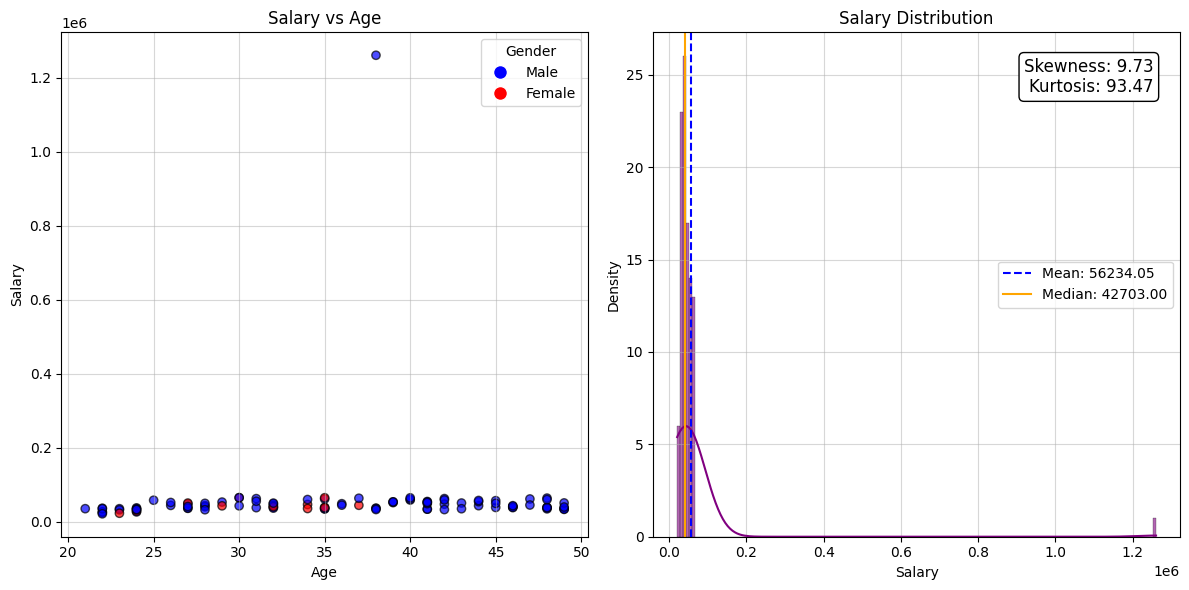

In [ ]:
%pip install seaborn --quiet

import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

colors = salary_df['Gender'].map({'Male': 'blue', 'Female': 'red'})
ax[0].scatter(salary_df['Age'], salary_df['Salary'], c=colors, alpha=0.7, edgecolor='k')
ax[0].set_title('Salary vs Age')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Salary')
ax[0].grid(alpha=0.5)
ax[0].legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Male', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Female', markerfacecolor='red', markersize=10)
], title="Gender")

sns.histplot(salary_df['Salary'], kde=True, ax=ax[1], color='purple', alpha=0.6)
ax[1].set_title('Salary Distribution')
ax[1].set_xlabel('Salary')
ax[1].set_ylabel('Density')
ax[1].grid(alpha=0.5)

mean_salary = salary_df['Salary'].mean()
median_salary = salary_df['Salary'].median()
ax[1].axvline(mean_salary, color='blue', linestyle='--', label=f'Mean: {mean_salary:.2f}')
ax[1].axvline(median_salary, color='orange', linestyle='-', label=f'Median: {median_salary:.2f}')
ax[1].legend()

salary_skew = skew(salary_df['Salary'])
salary_kurtosis = kurtosis(salary_df['Salary'])

text_info = f"Skewness: {salary_skew:.2f}\nKurtosis: {salary_kurtosis:.2f}"
ax[1].text(0.95, 0.95, text_info, transform=ax[1].transAxes, fontsize=12,
           verticalalignment='top', horizontalalignment='right',
           bbox=dict(boxstyle="round", facecolor="white", edgecolor="black"))

plt.tight_layout()
plt.show()

Hard to understand how the data is distributted when a few high-earners have skewed our distribution. Also this is quantified in the skew and kurtosis.

Let's drop the millionaire using the Z-Score technique, do you think we will experience the same issue as in the lesson?

Z-score equation:

$$
Z = \frac{X - \mu}{\sigma}
$$
$$
\text{outliers} = Z < -3 \quad \text{or} \quad Z > 3
$$


In [ ]:
mu = salary_df['Salary'].mean()
sigma = salary_df['Salary'].std()

salary_df['Salary_Z'] = (salary_df['Salary'] - mu) / sigma

salary_df = salary_df.sort_values('Salary_Z', ascending=False)
salary_df.head(3)

,Name,Age,Salary,Gender,Department,Reports_To,Salary_Z
91,Person_91,38,1260260,Male,Marketing,Manager,9.860782
87,Person_87,30,64745,Male,Marketing,Manager,0.069703
39,Person_39,30,64711,Female,Engineering,Manager,0.069425


The millionaire is 9 standard deviations from the mean.
Since we detected them as an outlier, we can drop them.

In [ ]:
salary_df = salary_df[(salary_df['Salary_Z'] >= -3) & (salary_df['Salary_Z'] <= 3)]
salary_df.head(3)

,Name,Age,Salary,Gender,Department,Reports_To,Salary_Z
87,Person_87,30,64745,Male,Marketing,Manager,0.069703
39,Person_39,30,64711,Female,Engineering,Manager,0.069425
76,Person_76,35,64635,Female,HR,Manager,0.068802


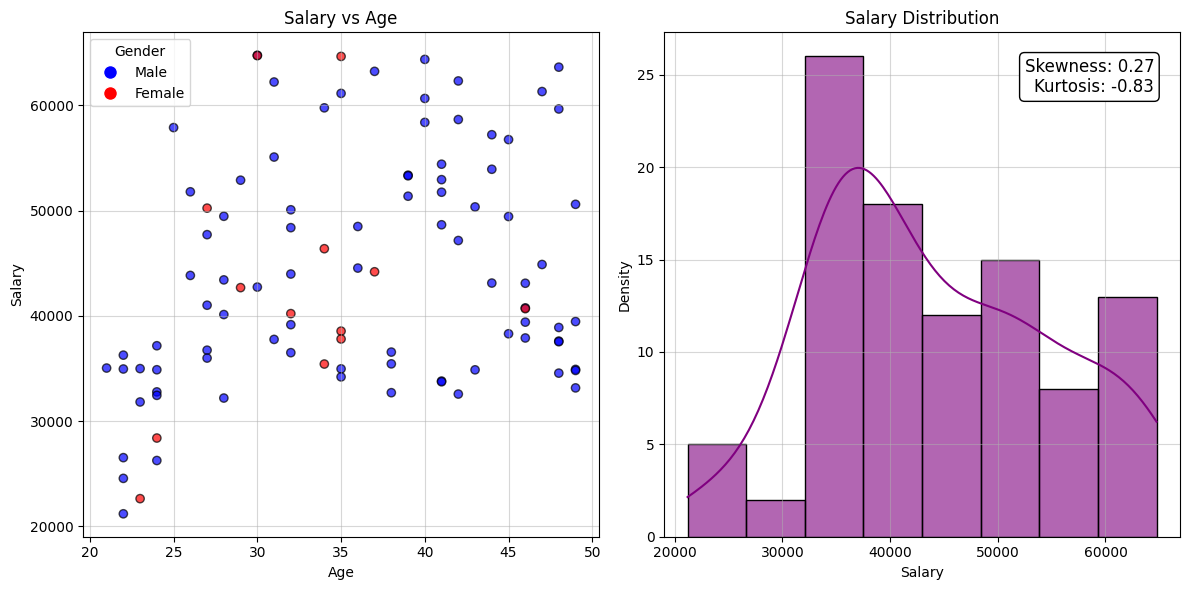

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot
colors = salary_df['Gender'].map({'Male': 'blue', 'Female': 'red'})
ax[0].scatter(salary_df['Age'], salary_df['Salary'], c=colors, alpha=0.7, edgecolor='k')
ax[0].set_title('Salary vs Age')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Salary')
ax[0].grid(alpha=0.5)
ax[0].legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Male', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Female', markerfacecolor='red', markersize=10)
], title="Gender")

# Salary distribution
sns.histplot(salary_df['Salary'], kde=True, ax=ax[1], color='purple', alpha=0.6)
ax[1].set_title('Salary Distribution')
ax[1].set_xlabel('Salary')
ax[1].set_ylabel('Density')
ax[1].grid(alpha=0.5)


salary_skew = skew(salary_df['Salary'])
salary_kurtosis = kurtosis(salary_df['Salary'])

text_info = f"Skewness: {salary_skew:.2f}\nKurtosis: {salary_kurtosis:.2f}"
ax[1].text(0.95, 0.95, text_info, transform=ax[1].transAxes, fontsize=12,
           verticalalignment='top', horizontalalignment='right',
           bbox=dict(boxstyle="round", facecolor="white", edgecolor="black"))

plt.tight_layout()
plt.show()

Much better to visualize.

How's this different from the lesson's results. The `mean` did the difference, in the lesson we had a small sample, in the dataset we have much more and have pulled the mean into a reasonable range.

### Feature Scaling

In the lesson we went through standardization and normalization techniques.
We already used the scalers in the previous notebook, let's see their effect visualy on the data.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler_standard = StandardScaler()
salary_df['Salary_Standardized'] = scaler_standard.fit_transform(salary_df[['Salary']])
scaler_normal = MinMaxScaler()
salary_df['Salary_Normalized'] = scaler_normal.fit_transform(salary_df[['Salary']])

print(salary_df['Salary_Standardized'].describe())
print(salary_df['Salary_Normalized'].describe())

count    9.900000e+01
mean     8.971499e-18
std      1.005089e+00
min     -2.106841e+00
25%     -8.144247e-01
50%     -1.284976e-01
75%      7.604675e-01
max      1.904002e+00
Name: Salary_Standardized, dtype: float64
count    99.000000
mean      0.525286
std       0.250593
min       0.000000
25%       0.322231
50%       0.493249
75%       0.714889
max       1.000000
Name: Salary_Normalized, dtype: float64


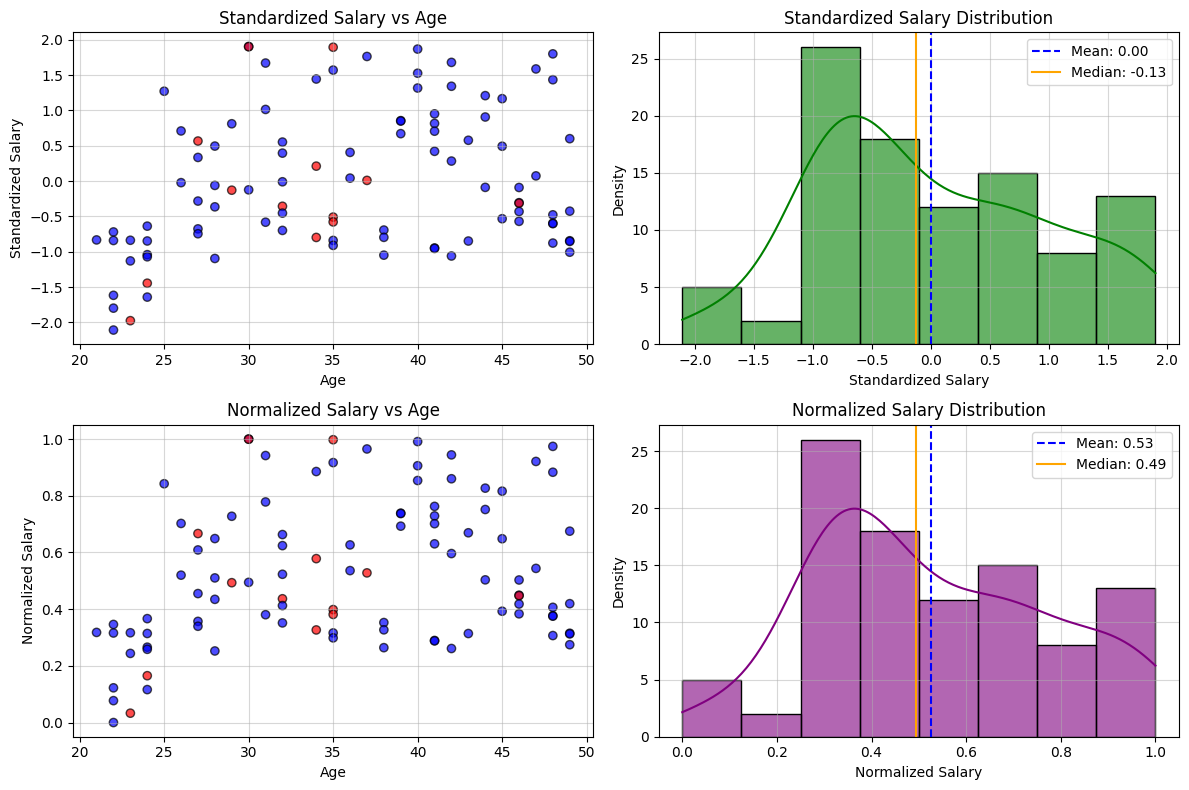

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

colors = salary_df['Gender'].map({'Male': 'blue', 'Female': 'red'})
ax[0, 0].scatter(salary_df['Age'], salary_df['Salary_Standardized'], c=colors, alpha=0.7, edgecolor='k')
ax[0, 0].set_title('Standardized Salary vs Age')
ax[0, 0].set_xlabel('Age')
ax[0, 0].set_ylabel('Standardized Salary')
ax[0, 0].grid(alpha=0.5)

sns.histplot(salary_df['Salary_Standardized'], kde=True, ax=ax[0, 1], color='green', alpha=0.6)
ax[0, 1].set_title('Standardized Salary Distribution')
ax[0, 1].set_xlabel('Standardized Salary')
ax[0, 1].set_ylabel('Density')
mean_standardized = salary_df['Salary_Standardized'].mean()
median_standardized = salary_df['Salary_Standardized'].median()
ax[0, 1].axvline(mean_standardized, color='blue', linestyle='--', label=f'Mean: {mean_standardized:.2f}')
ax[0, 1].axvline(median_standardized, color='orange', linestyle='-', label=f'Median: {median_standardized:.2f}')
ax[0, 1].legend()
ax[0, 1].grid(alpha=0.5)

ax[1, 0].scatter(salary_df['Age'], salary_df['Salary_Normalized'], c=colors, alpha=0.7, edgecolor='k')
ax[1, 0].set_title('Normalized Salary vs Age')
ax[1, 0].set_xlabel('Age')
ax[1, 0].set_ylabel('Normalized Salary')
ax[1, 0].grid(alpha=0.5)

sns.histplot(salary_df['Salary_Normalized'], kde=True, ax=ax[1, 1], color='purple', alpha=0.6)
ax[1, 1].set_title('Normalized Salary Distribution')
ax[1, 1].set_xlabel('Normalized Salary')
ax[1, 1].set_ylabel('Density')
mean_normalized = salary_df['Salary_Normalized'].mean()
median_normalized = salary_df['Salary_Normalized'].median()
ax[1, 1].axvline(mean_normalized, color='blue', linestyle='--', label=f'Mean: {mean_normalized:.2f}')
ax[1, 1].axvline(median_normalized, color='orange', linestyle='-', label=f'Median: {median_normalized:.2f}')
ax[1, 1].legend()
ax[1, 1].grid(alpha=0.5)

plt.tight_layout()
plt.show()


### SMOTE


SMOTE is an advanced resampling technique.


For SMOTE we will load the its [APIs](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html). Link to the original paper [here](https://arxiv.org/abs/1106.1813).

To use smote you will need to install imbalanced-learn library if you are running this notebook on your machine with `pip install imbalanced-learn`.



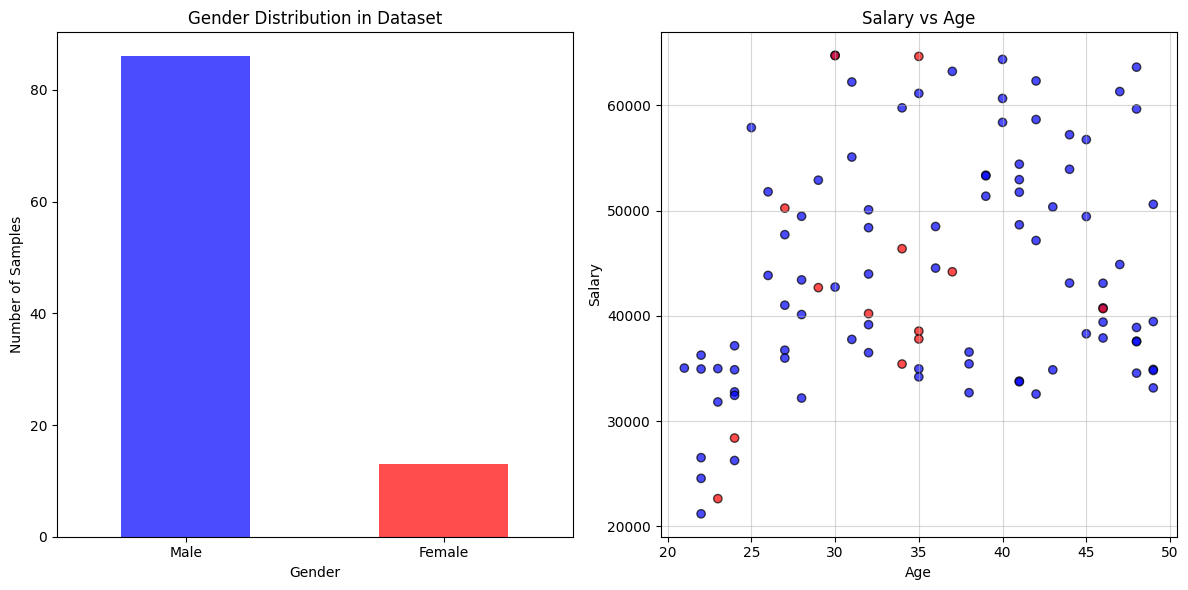

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

class_distribution = salary_df['Gender'].value_counts()
class_distribution.plot(kind='bar', color=['blue', 'red'], alpha=0.7, ax=axes[0])
axes[0].set_title('Gender Distribution in Dataset')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Number of Samples')
axes[0].set_xticklabels(class_distribution.index, rotation=0)

colors = salary_df['Gender'].map({'Male': 'blue', 'Female': 'red'})
axes[1].scatter(salary_df['Age'], salary_df['Salary'], c=colors, alpha=0.7, edgecolor='k', label='Gender')
axes[1].set_title('Salary vs Age')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Salary')
axes[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()

As we see, the labels are unbalanced. Females make up only 20% of the dataset, causing models trained on this to have a male bais. We will use the SMOTE algo to generate as much synthetic Female data as Male.

Note how we extract the variables into one feature vector `X`, and the gender label `y`.

In [ ]:
from imblearn.over_sampling import SMOTE

KNN_COUNT = 3

X = salary_df[['Age', 'Salary']].copy()
y = salary_df['Gender'].copy()

smote = SMOTE(sampling_strategy='minority', k_neighbors = KNN_COUNT)
X_resampled, y_resampled = smote.fit_resample(X, y)

salary_resampled_df = pd.DataFrame(X_resampled, columns=['Age', 'Salary'])
salary_resampled_df['Gender'] = y_resampled
salary_resampled_df['SMOTE_Label'] = 'Original'
salary_resampled_df.loc[len(salary_df):, 'SMOTE_Label'] = 'SMOTE'

smote_samples_df = salary_resampled_df[salary_resampled_df['SMOTE_Label'] == 'SMOTE']
smote_samples_df.sample(3)

,Age,Salary,Gender,SMOTE_Label
170,30,41697,Female,SMOTE
126,28,57288,Female,SMOTE
102,44,40417,Female,SMOTE


Let's visualize below the oversampled dataset.

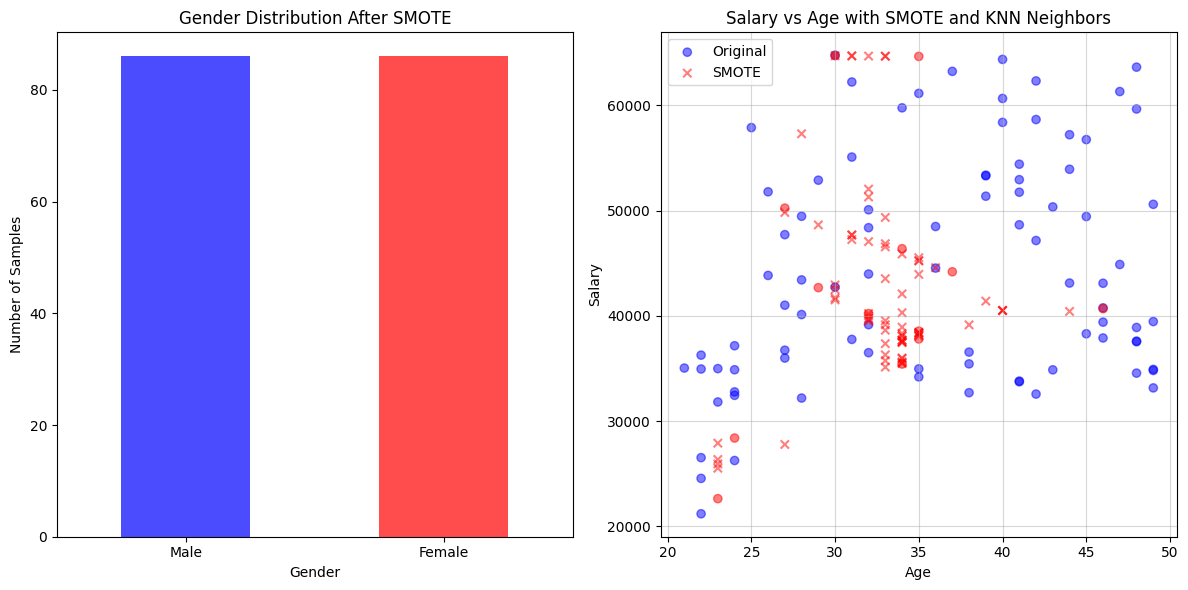

In [ ]:
marker_map = {'Original': 'o', 'SMOTE': 'x'}
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

class_distribution_resampled = salary_resampled_df['Gender'].value_counts()
class_distribution_resampled.plot(kind='bar', color=['blue', 'red'], alpha=0.7, ax=axes[0])
axes[0].set_title('Gender Distribution After SMOTE')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Number of Samples')
axes[0].set_xticks(range(len(class_distribution_resampled.index)))
axes[0].set_xticklabels(class_distribution_resampled.index, rotation=0)

axes[1].scatter(
    salary_df['Age'],
    salary_df['Salary'],
    c=salary_df['Gender'].map({'Male': 'blue', 'Female': 'red'}),
    alpha=0.5,
    marker=marker_map["Original"],
    label="Original"
)
axes[1].scatter(
    smote_samples_df['Age'],
    smote_samples_df['Salary'],
    c=smote_samples_df['Gender'].map({'Male': 'blue', 'Female': 'red'}),
    alpha=0.5,
    marker=marker_map["SMOTE"],
    label="SMOTE"
)

axes[1].set_title('Salary vs Age with SMOTE and KNN Neighbors')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Salary')
axes[1].grid(alpha=0.5)
axes[1].legend()
plt.tight_layout()
plt.show()

Now, our data is balanced. Let's do our own algo to see how it worked:

1. Find its k nearest neighbors: For the current data point, SMOTE finds its k nearest neighbors within the minority class.

2. Pick one of the neighbors randomly: SMOTE randomly selects one of these k neighbors.

3. Create a new, synthetic data point: SMOTE creates a new data point somewhere on the line between the current data point and the randomly chosen neighbor.

4. For each feature (e.g., age, salary):
  - Calculate the difference between the feature value of the current point and the neighbor.
  - Multiply this difference by a random number between 0 and 1.
  - Add this result to the feature value of the current point.

5. Repeat: Steps 2 and 4 are repeated until we have generated the desired number of synthetic data points.

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
def learn_smote(X_df, y_df, N=100, k=5):
    minority_class_label = y_df.value_counts().idxmin()
    minority_indices = y_df[y_df == minority_class_label].index
    print(f"Number of minority samples: {len(minority_indices)}: {minority_indices}")
    print(f"Minority class label: {minority_class_label}")
    T = len(minority_indices)
    N = int(N / 100)
    synthetic = pd.DataFrame(columns=X_df.columns)
    synthetic_y = pd.Series()

    nbrs_idx = []
    nbrs = NearestNeighbors(n_neighbors=k).fit(X_df.loc[minority_indices])

    for i in minority_indices:
        nnarray = nbrs.kneighbors(X_df.loc[[i]], return_distance=False)[0]
        for j in range(N):
            nn = np.random.choice(nnarray)
            nbrs_idx.append(minority_indices[nnarray])
            neighbor = X_df.loc[minority_indices[nn]]
            new_sample = X_df.loc[i] + np.random.random() * (neighbor - X_df.loc[i])
            synthetic = pd.concat([synthetic, new_sample.to_frame().T], ignore_index=True)
            synthetic_y = pd.concat([synthetic_y, pd.Series([minority_class_label])], ignore_index=True)

    synthetic['KNN'] = nbrs_idx
    synthetic['SMOTE_Label'] = "SMOTE"
    X_df['KNN'] = None
    X_df['SMOTE_Label'] = "Original"
    resampled_df = pd.concat([X_df, synthetic], axis=0, ignore_index=True)
    resampled_y = pd.concat([y_df, synthetic_y.to_frame()], axis=0, ignore_index=True)

    return resampled_df, resampled_y

class_counts = salary_df['Gender'].value_counts()
num_minority = class_counts.get('Female', 0)
num_majority = class_counts.get('Male', 0)
N = ((num_majority - num_minority) / num_minority) * 100

X = salary_df[['Age', 'Salary']].copy()
y = salary_df['Gender'].copy()

resampled_df, resampled_y = learn_smote(X, y, N=N, k=KNN_COUNT)
resampled_df['Gender'] = resampled_y
smote_samples_df = resampled_df[resampled_df['SMOTE_Label'] == 'SMOTE']
smote_samples_df.sample(3)

Number of minority samples: 13: Index([39, 76, 8, 61, 36, 64, 9, 73, 3, 99, 78, 83, 77], dtype='int64')
Minority class label: Female


,Age,Salary,KNN,SMOTE_Label,Gender
151,34.000000,35420.000000,"Index([78, 99, 3], dtype='int64')",SMOTE,Female
157,25.295149,29302.230867,"Index([83, 77, 78], dtype='int64')",SMOTE,Female
118,34.265630,46179.089931,"Index([61, 36, 64], dtype='int64')",SMOTE,Female


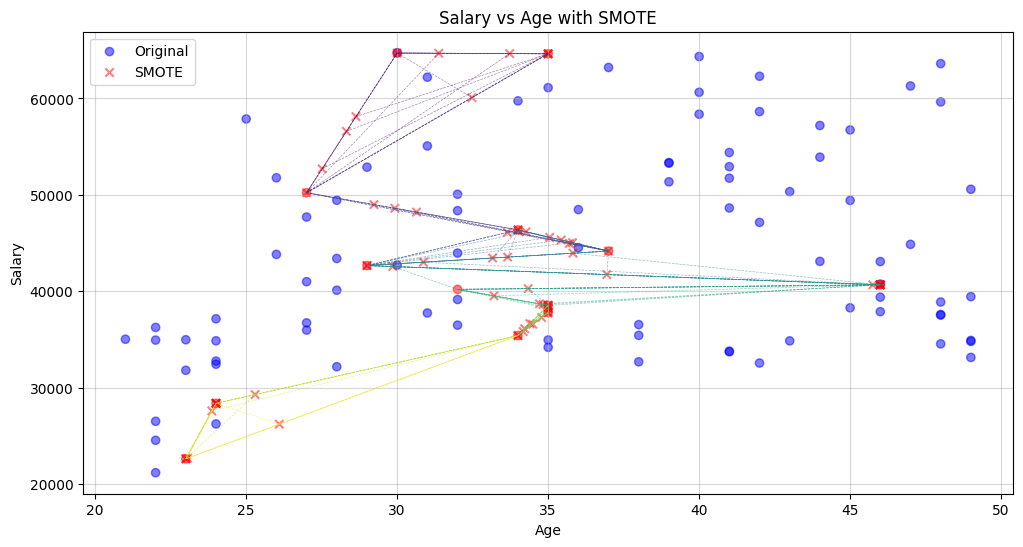

In [ ]:
fig = plt.figure(1, figsize=(12, 6))

for smote_label, marker in marker_map.items():
    subset = resampled_df[resampled_df['SMOTE_Label'] == smote_label]
    plt.scatter(
        subset['Age'],
        subset['Salary'],
        c=subset['Gender'].map({'Male': 'blue', 'Female': 'red'}),
        alpha=0.5,
        marker=marker,
        label=smote_label
    )

color_cycle = plt.get_cmap('viridis', smote_samples_df.shape[0])
for i, (index, row) in enumerate(smote_samples_df.iterrows()):
    assert row['KNN'] is not None
    current_color = color_cycle(i)
    for neighbor_index in row['KNN']:
      neighbor = salary_df.loc[neighbor_index]
      plt.plot(
          [row['Age'], neighbor['Age']],
          [row['Salary'], neighbor['Salary']],
          color=current_color,
          alpha=0.5,
          linestyle='--',
          linewidth = 0.5
      )
plt.title('Salary vs Age with SMOTE')
plt.xlabel('Age')
plt.ylabel('Salary')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

# Web Scraping

for websraping, we use a library called `BeautifulSoup` which allows us query the HTML using XPath or simple APIs. Read about it [here](https://www.crummy.com/software/BeautifulSoup/bs4/doc/).

In [ ]:
%pip install beautifulsoup4 requests --quiet

import requests
from bs4 import BeautifulSoup


We want to programmatically find out the most rectent update date in the web scraping wikipedia entry.

In [ ]:
url = "https://en.wikipedia.org/wiki/Web_scraping"
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, "html.parser")
    last_updated = soup.find("li", id="footer-info-lastmod").get_text()
    print(f"Last Updated: {last_updated}")
else:
    print(f"Erro. Status code: {response.status_code}")

Last Updated:  This page was last edited on 23 January 2025, at 14:43 (UTC).


# Knowledge Graphs

This section is an introducation to knowledge graphs. We will be using the library `NetworkX`, read bout it [here](https://networkx.org/). To alter the plot, check the draw [API](https://networkx.org/documentation/stable/reference/drawing.html).

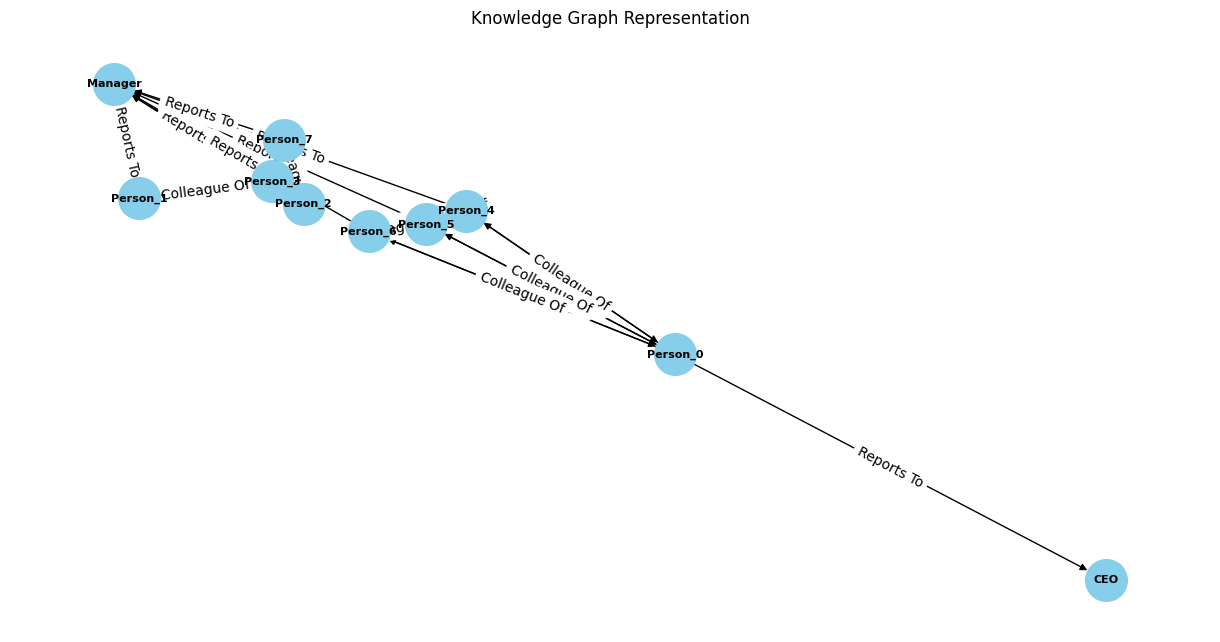

In [ ]:
%pip install networkx --quiet

import networkx as nx

SMALL_KG_SAMPLES = 8

salary_df = generate_salary_toydataset(n=SMALL_KG_SAMPLES)

G = nx.DiGraph()  # Directed better representation of relationships
for _, row in salary_df.iterrows():
    G.add_node(
        row['Name'],
        age=row['Age'],
        salary=row['Salary'],
        gender=row['Gender'],
        department=row['Department']
    )

for _, row in salary_df.iterrows():
    if row['Reports_To'] != 'None':
        G.add_edge(row['Name'], row['Reports_To'], relation='Reports To')

for department in DEPARTMENTS:
    dept_members = salary_df[salary_df['Department'] == department]['Name'].tolist()
    for i, person_a in enumerate(dept_members):
        for person_b in dept_members[i + 1:]:
            G.add_edge(person_a, person_b, relation='Colleague Of')
            G.add_edge(person_b, person_a, relation='Colleague Of')

plt.figure(figsize=(12, 6))
pos = nx.spring_layout(G)
nx.draw(
    G, pos,
    with_labels=True,
    node_size=900,
    node_color="skyblue",
    font_size=8,
    font_weight="bold"
)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'relation'))
plt.title("Knowledge Graph Representation")
plt.show()

Find the neighbors of a specific node (e.g., 'Person_0') and the degree of their node (both in-degree and out-degree).

In [ ]:
node = 'Person_0'
neighbors = list(G.neighbors(node))
print(f"Neighbors of {node}: {neighbors}")

in_degree = G.in_degree(node)
out_degree = G.out_degree(node)
print(f"In-Degree of {node}: {in_degree}")
print(f"Out-Degree of {node}: {out_degree}")

Neighbors of Person_0: ['CEO', 'Person_4', 'Person_5', 'Person_6']
In-Degree of Person_0: 3
Out-Degree of Person_0: 4


Find nodes with a specific relationship (e.g., 'Reports To')

In [ ]:
relationship = 'Reports To'
reports_to_edges = [(u, v) for u, v, d in G.edges(data=True) if d['relation'] == relationship]
print(f"Edges with relationship '{relationship}': {reports_to_edges}")

Edges with relationship 'Reports To': [('Person_0', 'CEO'), ('Person_1', 'Manager'), ('Person_2', 'Manager'), ('Person_3', 'Manager'), ('Person_4', 'Manager'), ('Person_5', 'Manager'), ('Person_6', 'Manager'), ('Person_7', 'Manager')]


Find all paths between two nodes (e.g., 'Person_7' and 'CEO')

In [ ]:
target_node = 'CEO'
node = 'Person_6'

all_paths = list(nx.all_simple_paths(G, source=node, target=target_node))
print(f"All paths from {node} to {target_node}: {all_paths}")

All paths from Person_6 to CEO: [['Person_6', 'Person_0', 'CEO'], ['Person_6', 'Person_4', 'Person_0', 'CEO'], ['Person_6', 'Person_4', 'Person_5', 'Person_0', 'CEO'], ['Person_6', 'Person_5', 'Person_0', 'CEO'], ['Person_6', 'Person_5', 'Person_4', 'Person_0', 'CEO']]


Find the shortest path between two nodes (e.g., 'Person_4' and 'Manager')

In [ ]:
node = 'Person_4'
try:
    shortest_path = nx.shortest_path(G, source=node, target='Manager')
    print(f"Shortest path from {node} to 'Manager': {shortest_path}")
except nx.NetworkXNoPath:
    print(f"No path exists between {node} and 'Manager'.")

Shortest path from Person_4 to 'Manager': ['Person_4', 'Manager']


Identify isolated nodes (nodes without any edges)

In [ ]:
isolated_nodes = list(nx.isolates(G))
print(f"Isolated nodes: {isolated_nodes}")

Isolated nodes: []


Visualize subgraph of a specific department (e.g., 'Engineering')

Employees in Engineering: ['Person_0', 'Person_4', 'Person_5', 'Person_6']


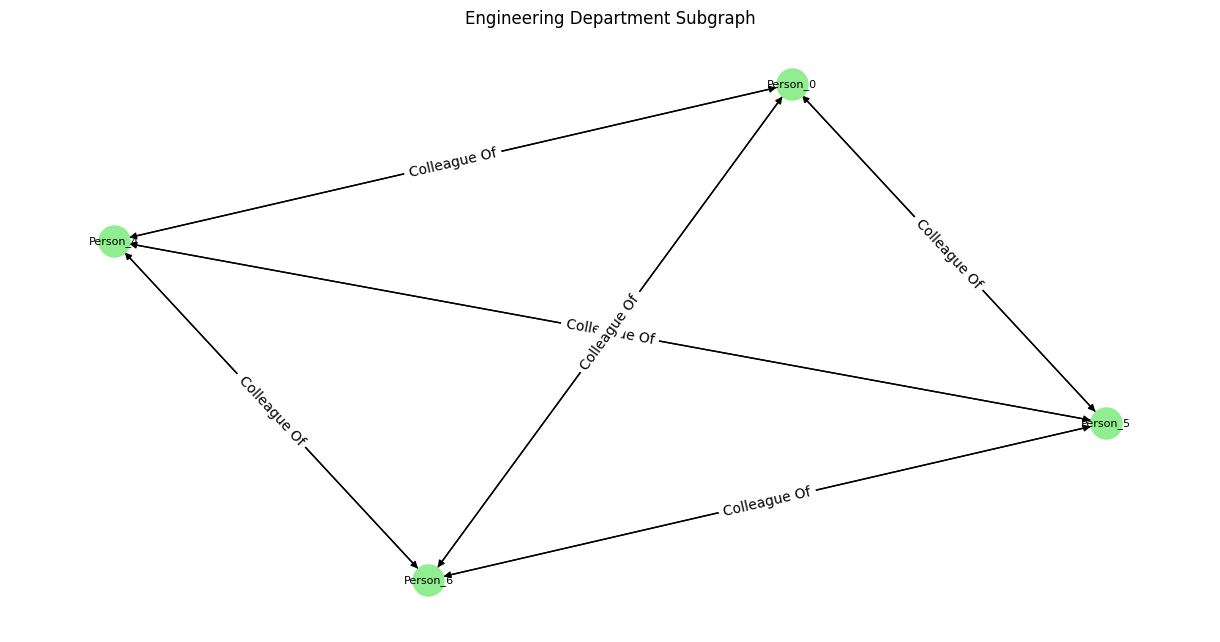

In [ ]:
engineering_employees = [node for node, attr in G.nodes(data=True) if attr.get('department') == DEPARTMENTS[1]]
print("Employees in Engineering:", engineering_employees)

engineering_subgraph = G.subgraph(engineering_employees)
plt.figure(figsize=(12, 6))
pos = nx.spring_layout(engineering_subgraph)
nx.draw(engineering_subgraph, pos, with_labels=True, node_size=500, node_color="lightgreen", font_size=8)
nx.draw_networkx_edge_labels(engineering_subgraph, pos, edge_labels=nx.get_edge_attributes(engineering_subgraph, 'relation'))
plt.title("Engineering Department Subgraph")
plt.show()

# Big Data

In this section we will look in pytorch, parquet files, and techniques to handle data that is just too large to load in your memory!

In [ ]:
%pip install pyarrow --quiet

import pyarrow as pa
import pyarrow.parquet as pq
from tqdm.notebook import tqdm


BIGDATA_SAMPLES = 1_000_000
salary_df = generate_salary_toydataset(n=BIGDATA_SAMPLES)
print(f"Dataset Shape: {salary_df.shape}")

arrow_table = pa.Table.from_pandas(salary_df)
pq.write_table(arrow_table, "./large_salary_data.parquet", compression="snappy")

# Function to process large Parquet file in batches
def process_large_parquet(file_path, batch_size=100_000):
    parquet_file = pq.ParquetFile(file_path)
    print(f"Number of rows in file: {parquet_file.metadata.num_rows}")

    for i, batch in enumerate(parquet_file.iter_batches(batch_size=batch_size)):
        df_batch = pa.Table.from_batches([batch]).to_pandas()
        avg_salary = df_batch["Salary"].mean()
        print(f"Chunk {i + 1} - Average Salary: {avg_salary:.2f}")
        yield avg_salary

for avg_salary in tqdm(process_large_parquet("./large_salary_data.parquet"), desc="Processing Parquet File", leave=False):
    pass  # Replace with operations to perform on the chunk

# Columnar operations on specific columns
selected_columns = ["Age", "Salary"]
column_table = pq.read_table("./large_salary_data.parquet", columns=selected_columns)
age_salary_df = column_table.to_pandas()
age_salary_df["Age Group"] = pd.cut(
    age_salary_df["Age"],
    bins=[18, 25, 35, 45, 55, 65],
    labels=["18-25", "26-35", "36-45", "46-55", "56-65"]
)
summary = age_salary_df.groupby("Age Group")["Salary"].mean()
print("Average Salary by Age Group:")
print(summary)


Dataset Shape: (1000000, 6)


Processing Parquet File: 0it [00:00, ?it/s]

Number of rows in file: 1000000
Chunk 1 - Average Salary: 57541.25
Chunk 2 - Average Salary: 57307.07
Chunk 3 - Average Salary: 57079.05
Chunk 4 - Average Salary: 57744.40
Chunk 5 - Average Salary: 57436.26
Chunk 6 - Average Salary: 57059.69
Chunk 7 - Average Salary: 57190.19
Chunk 8 - Average Salary: 57923.00
Chunk 9 - Average Salary: 57425.60
Chunk 10 - Average Salary: 57419.97
Average Salary by Age Group:
Age Group
18-25    44435.500000
26-35    59861.890515
36-45    60191.704447
46-55    60626.287270
56-65             NaN
Name: Salary, dtype: float64


In [ ]:
%pip install dask distributed jupyter-dash --quiet

from dask.distributed import Client
import dask.dataframe as dd

client = Client()
ddf = dd.from_pandas(salary_df, npartitions=2)

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:33041
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:46189'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43669'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:40519 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:40519
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:34258
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:43961 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:43961
INFO:distributed.core:Starting established connection to tcp://127

Distributed group-by operation

In [ ]:
result = ddf.groupby("Gender")["Salary"].mean().compute()
print("Average Salary by Gender:")
result

Average Salary by Gender:


,Salary
Gender,
Female,57422.441691
Male,57411.560495


 Distributed Add an Age Group column

In [ ]:
ddf = ddf.assign(Age_Group=(ddf["Age"] // 10 * 10))
ddf.compute()

,Name,Age,Salary,Gender,Department,Reports_To,Age_Group
0,Person_0,27,42509,Male,Sales,CEO,20
1,Person_1,40,38713,Male,Sales,Manager,40
2,Person_2,49,43356,Male,Marketing,Manager,40
3,Person_3,35,46316,Male,Engineering,Manager,30
4,Person_4,31,48614,Male,Marketing,Manager,30
...,...,...,...,...,...,...,...
999995,Person_999995,23,24837,Male,Sales,Manager,20
999996,Person_999996,26,61754,Male,Engineering,Manager,20
999997,Person_999997,47,34617,Male,HR,Manager,40
999998,Person_999998,39,38439,Male,Engineering,Manager,30


Distributed computation doing Average salary by gender

In [ ]:
ddf_large = dd.from_pandas(salary_df, npartitions=10)

result_large = ddf_large.groupby("Gender")["Salary"].mean().compute()
print("Average Salary by Gender (Large Dataset):")
result_large

Average Salary by Gender (Large Dataset):


,Salary
Gender,
Female,57422.441691
Male,57411.560495


# Conclussion

This is the end of dataengineering. In this notebook we have encountered a wide variety of tools. This notebook was more exploratory, allowing you to understand various processes and subsystems that lead to a good AI.